In [1]:
# sarcasm json data binary classification
# total 26,709 headlines  

In [2]:
import json
import tensorflow as tf
import urllib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Colab용 
# !wget --no-check-certificate \
#     https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json \
#     -O /tmp/sarcasm.json

In [4]:
# sarcasm.json 데이터셋 파일 다운로드 
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

('sarcasm.json', <http.client.HTTPMessage at 0x22bcdbfc8e0>)

In [5]:
# 데이터 파일 불러오기
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [6]:
print(sentences[:5])  # X
labels[:5]            # Y

["former versace store clerk sues over secret 'black code' for minority shoppers", "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "mom starting to fear son's web series closest thing she will have to grandchild", 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas', 'j.k. rowling wishes snape happy birthday in the most magical way']


[0, 0, 1, 1, 0]

In [7]:
# 데이터 프레임으로 보기(참고)
import pandas as pd
df = pd.DataFrame(datastore)
df = df.iloc[:,1:]

print(type(datastore[0]))  # <class 'dict'>
print(df.shape)            # (26709, 2)
print(df['is_sarcastic'].value_counts())   # 0    14985 : not sarcastic 
                                           # 1    11724 : sarcastic
df.head(10)

<class 'dict'>
(26709, 2)
0    14985
1    11724
Name: is_sarcastic, dtype: int64


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
5,advancing the world's women,0
6,the fascinating case for eating lab-grown meat,0
7,"this ceo will send your kids to school, if you...",0
8,top snake handler leaves sinking huckabee camp...,1
9,friday's morning email: inside trump's presser...,0


### 텍스트 전처리

In [9]:
# 전처리를 위한 변수 설정
vocab_size = 10000      # 토큰화에 사용될 최대 어휘수
embedding_dim = 16      # Embedding 계층의 output size 
max_length = 100        # 한 문장의 길이, 데이터 셋의 길이, maxlen,sequence length
trunc_type = 'post'     # remove values from sequences larger than  `maxlen`
padding_type = 'post'   # padding 방식
oov_tok = '<OOV>'       # Out-Of-Vocabulary(단어 집합에 없는 단어)
training_size = 20000   # 학습 데이터의 갯수

In [14]:
# train(20000)/test(6709) data split 
training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[:training_size]
testing_labels = labels[training_size:]

In [45]:
# 토큰나이저를 시행하여 단어를 숫자값, 인덱스로 변환하여 저장

# 가장 빈도가 높은 10000개의 단어들만 사용하여 토큰화
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
# print(tokenizer)

# 단어 인덱스를 생성
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
# print(word_index)

# 문자열을 정수 인덱스의 리스트로 변환 : 정수 인코딩
training_sequences = tokenizer.texts_to_sequences(training_sentences)
print(type(training_sequences))  # <class 'list'>

# 패딩, 벡터 표현을 얻음 : 신경망에 입력할 X값, ndarray로 출력
training_padded = pad_sequences(training_sequences,maxlen=max_length,
                               padding=padding_type,truncating=trunc_type)

print(type(training_padded))

# test용 단어 인덱스를 따로 만들지 않고 train용 인덱스를 사용한다
# test 데이터 : 정수 인덱스의 리스트로 변환,정수 인코딩
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

# test 데이터 패딩, 벡터 표현을 얻음 , ndarray로 출력
testing_padded = pad_sequences(testing_sequences,maxlen=max_length,
                               padding=padding_type,truncating=trunc_type)

print(training_padded.shape)  # (20000, 100)
print(testing_padded.shape)   # (6709, 100)

<class 'list'>
<class 'numpy.ndarray'>
(20000, 100)
(6709, 100)


In [49]:
# list를 ndarray 로 모두 변환
import numpy as np
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)
print(training_labels.shape)
print(testing_labels.shape)

(20000,)
(6709,)


In [55]:
# 학습모델
model = tf.keras.Sequential([
    # input : (None,100), ouput : (None,100,16)
    # Embedding layer Params : 10000*16 = 160000
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 24)                408       
                                                                 
 dense_6 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [56]:
# 학습
num_epochs = 30
history = model.fit(training_padded,training_labels,epochs=num_epochs,
                   validation_data=(testing_padded,testing_labels))

Epoch 1/30
625/625 [==============================] - 3s 2ms/step - loss: 0.6731 - accuracy: 0.5741 - val_loss: 0.6131 - val_accuracy: 0.7743
Epoch 2/30
625/625 [==============================] - 1s 2ms/step - loss: 0.4522 - accuracy: 0.8212 - val_loss: 0.3905 - val_accuracy: 0.8351
Epoch 3/30
625/625 [==============================] - 1s 2ms/step - loss: 0.3200 - accuracy: 0.8716 - val_loss: 0.3563 - val_accuracy: 0.8490
Epoch 4/30
625/625 [==============================] - 1s 2ms/step - loss: 0.2673 - accuracy: 0.8960 - val_loss: 0.3433 - val_accuracy: 0.8557
Epoch 5/30
625/625 [==============================] - 1s 2ms/step - loss: 0.2336 - accuracy: 0.9083 - val_loss: 0.3468 - val_accuracy: 0.8501
Epoch 6/30
625/625 [==============================] - 1s 2ms/step - loss: 0.2039 - accuracy: 0.9232 - val_loss: 0.3473 - val_accuracy: 0.8533
Epoch 7/30
625/625 [==============================] - 1s 2ms/step - loss: 0.1830 - accuracy: 0.9312 - val_loss: 0.3631 - val_accuracy: 0.8562
Epoch 

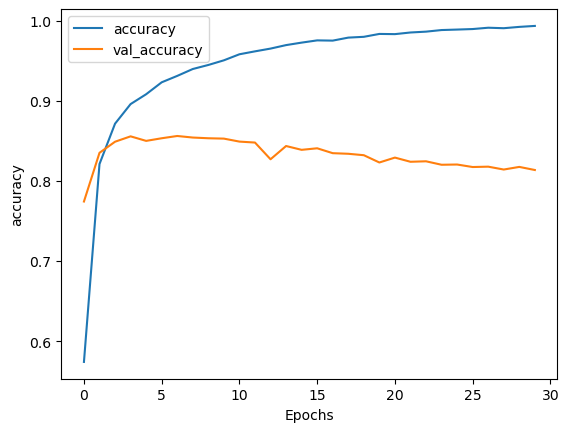

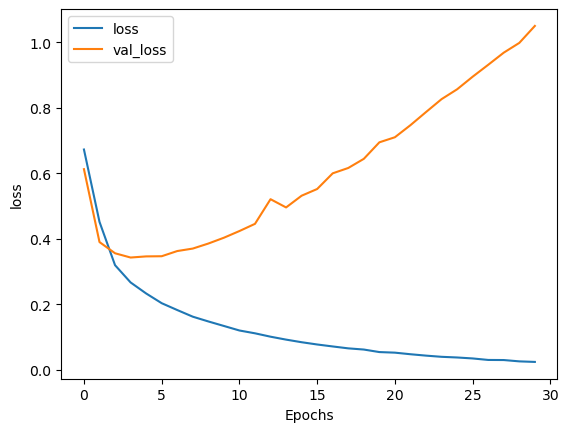

In [57]:
# 시각화
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [58]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[2]))
print(training_sentences[2])
print(labels[2])

mom starting to fear son's web series closest thing she will have to grandchild ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [68]:
# 파이썬 문법 : dict 의 value 가져오기
d = {'a':1,'b':2,'c':3}
print(d.get('a'))
print(d.get('b'))
print(d.get('c'))
print(d.get('d','?')) # key 'd'가 없을때는 '?'를 반환

1
2
3
?


In [76]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [80]:
# 예측
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]

sequences = tokenizer.texts_to_sequences(sentence)  # 정수 인코딩, 리스트
padded = pad_sequences(sequences,maxlen=max_length,padding=padding_type,
                      truncating=trunc_type)  # 패딩, ndarray로 반환
preds = model.predict(padded)
print(preds)
print(np.round(preds))

1/1 [==============================] - 0s 12ms/step
[[8.8876975e-01]
 [1.6511916e-05]]
[[1.]
 [0.]]


### 모델개선

In [86]:
# 단방향 LSTM
model = tf.keras.Sequential([
    # input : (None,100), ouput : (None,100,16)
    # Embedding layer Params : 10000*16 = 160000
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 16)           160000    
                                                                 
 lstm_7 (LSTM)               (None, 100, 64)           20736     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 195,329
Trainable params: 195,329
Non-trainable params: 0
_________________________________________________________________


In [88]:
# 양방향 LSTM : 출력이 hidden_size의 2배가 된다
model = tf.keras.Sequential([
    # input : (None,100), ouput : (None,100,16)
    # Embedding layer Params : 10000*16 = 160000
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 16)           160000    
                                                                 
 dropout (Dropout)           (None, 100, 16)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 128)         41472     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 100, 128)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)              

In [ ]:
# 학습 : 약 6분 소요(GPU)
num_epochs = 30
history = model.fit(training_padded,training_labels,epochs=num_epochs,
                   validation_data=(testing_padded,testing_labels))

Epoch 1/30
625/625 [==============================] - 13s 16ms/step - loss: 0.4230 - accuracy: 0.7918 - val_loss: 0.3362 - val_accuracy: 0.8568
Epoch 2/30
625/625 [==============================] - 9s 14ms/step - loss: 0.2344 - accuracy: 0.9060 - val_loss: 0.3518 - val_accuracy: 0.8511
Epoch 3/30
625/625 [==============================] - 9s 14ms/step - loss: 0.1627 - accuracy: 0.9378 - val_loss: 0.3657 - val_accuracy: 0.8518
Epoch 4/30
625/625 [==============================] - 8s 14ms/step - loss: 0.1113 - accuracy: 0.9581 - val_loss: 0.4247 - val_accuracy: 0.8466
Epoch 5/30
625/625 [==============================] - 9s 14ms/step - loss: 0.0853 - accuracy: 0.9693 - val_loss: 0.4697 - val_accuracy: 0.8417
Epoch 6/30
625/625 [==============================] - 9s 14ms/step - loss: 0.0639 - accuracy: 0.9772 - val_loss: 0.6000 - val_accuracy: 0.8347
Epoch 7/30
611/625 [============================>.] - ETA: 0s - loss: 0.0493 - accuracy: 0.9833